In [1]:
from process_childes import extract_utterances_by_age_and_adult_folder, clean_chinese_utterances_simple
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import numpy as np
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'  # or 'PingFang TC', 'HanaMinA', etc.
matplotlib.rcParams['axes.unicode_minus'] = False

import torch

# Get the vectors

In [2]:
# Load the data
data = clean_chinese_utterances_simple(extract_utterances_by_age_and_adult_folder("Mandarin"))

In [3]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

In [4]:
target_chars = {"把", "被", "給"}

# Filter child utterances by age
filtered_by_age = {
    age: [utt for utt in utts if any(char in utt for char in target_chars)]
    for age, utts in data["child"].items()
    if utts
}

# Filter adult utterances
filtered_by_age["adult"] = [
    utt for utt in data["adult"] if any(char in utt for char in target_chars)
]


In [5]:
filtered_by_age.keys()

dict_keys([4, 5, 6, 3, 2, 7, 8, 9, 10, 1, 0, 'adult'])

In [6]:
for group, utts in filtered_by_age.items():
    print(group, len(utts))

4 1747
5 2983
6 2674
3 1527
2 683
7 683
8 158
9 86
10 68
1 92
0 18
adult 18612


In [7]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertModel.from_pretrained("bert-base-chinese")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
def get_character_embeddings_by_group(data, target_chars):
    from transformers import BertTokenizer, BertModel
    import torch

    tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
    model = BertModel.from_pretrained("bert-base-chinese")
    model.eval()

    result = {"child": {}, "adult": {char: [] for char in target_chars}}

    # Handle children by age
    for age, utterances in data["child"].items():
        age_result = {char: [] for char in target_chars}
        for utt in utterances:
            if not any(char in utt for char in target_chars):
                continue
            inputs = tokenizer(utt, return_tensors="pt", truncation=True)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.squeeze(0)
            tokens = tokenizer.tokenize(utt)
            for i, token in enumerate(tokens):
                for char in target_chars:
                    if token == char:
                        age_result[char].append(embeddings[i].numpy())
        result["child"][age] = age_result

    # Handle adult group
    for utt in data["adult"]:
        if not any(char in utt for char in target_chars):
            continue
        inputs = tokenizer(utt, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.squeeze(0)
        tokens = tokenizer.tokenize(utt)
        for i, token in enumerate(tokens):
            for char in target_chars:
                if token == char:
                    result["adult"][char].append(embeddings[i].numpy())

    return result

In [8]:
target_chars = ["把", "被", "給"]
char_embeddings_by_group = get_character_embeddings_by_group(data, target_chars)

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


# Pickle the vectors

In [9]:
import os
import pickle

output_dir = "char_embeddings_by_group_all"
os.makedirs(output_dir, exist_ok=True)

for char, groups in char_embeddings_by_group.items():
    for group, vectors in groups.items():
        filename = f"{output_dir}/{char}_{group}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(vectors, f)


# Test PCA and plotting 

In [10]:
from sklearn.decomposition import PCA
import numpy as np

def reduce_embeddings(embeddings, n_components=2):
    all_vectors = np.vstack(embeddings)
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(all_vectors)
    return reduced


In [12]:
# Flatten all embeddings to reduce them together
group_labels = []
char_labels = []
vectors = []

for group, chars in char_embeddings_by_group.items():
    for char, embs in chars.items():
        for emb in embs:
            emb = np.array(emb)
            if emb.shape == (768,):  # Keep only valid embeddings
                vectors.append(emb)
                group_labels.append(group)
                char_labels.append(char)

# Reduce to 2D
reduced_vectors = reduce_embeddings(vectors)


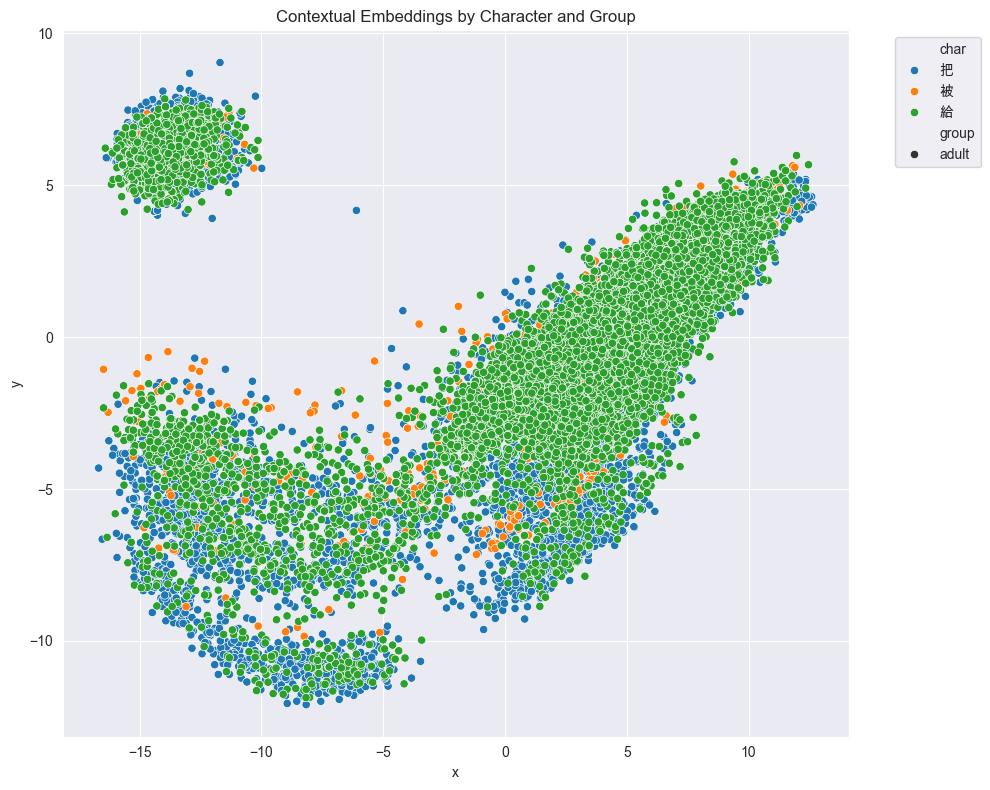

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Chinese characters display correctly
plt.rcParams["font.family"] = "Arial Unicode MS"  # or another font that supports Chinese

def plot_reduced_embeddings(reduced_vectors, group_labels, char_labels):
    plt.figure(figsize=(10, 8))
    df = {
        "x": [vec[0] for vec in reduced_vectors],
        "y": [vec[1] for vec in reduced_vectors],
        "group": group_labels,
        "char": char_labels
    }
    sns.scatterplot(x="x", y="y", hue="char", style="group", data=df)
    plt.title("Contextual Embeddings by Character and Group")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_reduced_embeddings(reduced_vectors, group_labels, char_labels)


In [14]:
char_embeddings_by_group.keys()

dict_keys(['child', 'adult'])

In [15]:
char_embeddings_by_group['child']

In [20]:
data['child'][0]

['雞 雞',
 '嘎',
 '呱呱 呱',
 '小 牛',
 '小 貓',
 '小 山羊',
 '把 兔子 交 給 我',
 '要 講 這 個',
 '小 魚',
 '小 魚 遊',
 '沒有 了',
 '扔 地 上',
 '嗯',
 '玩 玩具',
 '運動',
 '在 地 下 玩',
 '門',
 '把 這 個 拆 開',
 '還有 一 個',
 '還有 一 個 沒收 進去',
 '玩 玩具',
 '拿 這 個 玩具',
 '好',
 '這 邊',
 '要',
 '不 要',
 '要 玩具',
 '這 個 是',
 '門',
 '不 要',
 '紅 顏色',
 '白 顏色',
 '黃 顏色',
 '花 顏色',
 '不 收 玩具',
 '玩',
 '我 要 玩',
 '玩玩',
 '這 是 什麼',
 '這 是',
 '玩具',
 '白 顏色',
 '不 收 玩具',
 '好',
 '那 這 個',
 '放 這 個 裡面',
 '放 這 個 裡面',
 '預備 齊',
 '呵呵',
 '飛機',
 '不 玩 飛機',
 '嗯',
 '這 是 什麼',
 '還有',
 '快點',
 '沒有',
 '沒有',
 '還有 還有',
 '呵呵',
 '飛機',
 '嗚嗚',
 '這 是 什麼',
 '藍 顏色',
 '還有 還有',
 '嗯',
 '嗯',
 '不 要',
 '這 是 什麼',
 '這 是 什麼',
 '掉',
 '圓圈',
 '圓圓 臉 喲',
 '啊嗚',
 '這 是 什麼',
 '這 是 什麼',
 '茶水',
 '呵呵',
 '不 好',
 '不 要',
 '飛機',
 '好',
 '查',
 '十 一',
 '五 六 只 筆',
 '不 要 不 要',
 '還 寫',
 '嗯',
 '上面',
 '不 要 不 要',
 '不 要 不 要',
 '這 個 不 要',
 '嗯',
 '我 要 這 只 寫',
 '呵呵',
 '圓圓的 臉',
 '小 金 魚 遊 啊 遊',
 '好',
 '這 個',
 '不 會',
 '嗯',
 '掉 了',
 '眉毛',
 '不 要 玩 飛機',
 '我 要 開',
 '呵呵',
 '洗 手',
 '沒關係',
 '不 好',
 '蓋子 呢',
 '沒有',
 '你 的 手 沒有',
 '來 來',
 '為什麼

# 2nd version of embeddings with utterances in the dictionary 
(this allows us to look at examples in each cluster) 

In [23]:
target_chars = {"把", "被", "給"}

filtered_data = {
    "child": {
        age: [utt for utt in utts if any(char in utt for char in target_chars)]
        for age, utts in data["child"].items()
    },
    "adult": [
        utt for utt in data["adult"] if any(char in utt for char in target_chars)
    ]
}


def get_character_embeddings_by_group(data, target_chars):
    import torch
    from transformers import BertTokenizer, BertModel

    tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
    model = BertModel.from_pretrained("bert-base-chinese")
    model.eval()

    result = {"child": {}, "adult": {}}

    # Children by age
    for age, utterances in data["child"].items():
        group_result = {char: [] for char in target_chars}
        for utt in utterances:
            inputs = tokenizer(utt, return_tensors="pt", truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.squeeze(0)
            tokens = tokenizer.tokenize(utt)
            for i, token in enumerate(tokens):
                for char in target_chars:
                    if token == char:
                        group_result[char].append((embeddings[i].numpy(), utt))
        result["child"][age] = group_result

    # Adults
    group_result = {char: [] for char in target_chars}
    for utt in data["adult"]:
        inputs = tokenizer(utt, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.squeeze(0)
        tokens = tokenizer.tokenize(utt)
        for i, token in enumerate(tokens):
            for char in target_chars:
                if token == char:
                    group_result[char].append((embeddings[i].numpy(), utt))
    result["adult"] = group_result

    return result


In [24]:
char_embeddings_by_group = get_character_embeddings_by_group(filtered_data, ["把", "被", "給"])

In [24]:
# Summarize embeddings count
def summarize_embeddings(embeddings_by_group):
    for group in embeddings_by_group:
        print(f"Group: {group}")
        if group == "child":
            for age in sorted(embeddings_by_group[group]):
                print(f"  Age {age}:")
                for char, embeds in embeddings_by_group[group][age].items():
                    print(f"    {char}: {len(embeds)} embeddings")
        else:
            for char, embeds in embeddings_by_group[group].items():
                print(f"  {char}: {len(embeds)} embeddings")

summarize_embeddings(char_embeddings_by_group)


Group: child
  Age 把:


AttributeError: 'list' object has no attribute 'items'

In [29]:
import os, pickle
os.makedirs("char_embeddings_by_group_all_with_utts", exist_ok=True)

for group in char_embeddings_by_group:
    for key, vectors in char_embeddings_by_group[group].items():
        filename = f"char_embeddings_by_group_all_with_utts/{group}_{key}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(vectors, f)


In [7]:
import os
import pickle
from collections import defaultdict

input_dir = "char_embeddings_by_group_all_with_utts"
char_embeddings_by_group = defaultdict(lambda: defaultdict(list))

for filename in os.listdir(input_dir):
    if filename.endswith(".pkl"):
        char, group = filename.replace(".pkl", "").split("_")
        with open(os.path.join(input_dir, filename), "rb") as f:
            vectors = pickle.load(f)
            char_embeddings_by_group[char][group] = vectors


In [8]:
from load_embeddings import load_char_embeddings
char_embeddings_by_group = load_char_embeddings()


In [11]:
char_embeddings_by_group['child']['8'].keys()

dict_keys(['把', '被', '給'])

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Arial Unicode MS'  # or 'PingFang TC', 'HanaMinA', etc.
plt.rcParams['axes.unicode_minus'] = False

def plot_embeddings_pca(group_data, group_name):
    # Flatten and label
    embeddings = []
    labels = []
    for char, vecs in group_data.items():
        embeddings.extend([vec for vec, utt in vecs])
        labels.extend([char] * len(vecs))
    if len(embeddings) < 2:
        print(f"Not enough embeddings for {group_name}")
        return

    # Reduce
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(np.vstack(embeddings))

    # Plot
    fig = plt.figure(figsize=(6, 5))
    ls = list(set(labels))
    ls.sort()
    for char in ls:
        idxs = [i for i, lbl in enumerate(labels) if lbl == char]
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=char, s=3, alpha=1)
    plt.title(f"PCA - {group_name}")
    plt.legend()
    plt.ylim((-13,13))
    plt.xlim((-20,20))
    plt.grid(True)
    plt.show()
    return fig



In [34]:
import gc
gc.collect()


1424

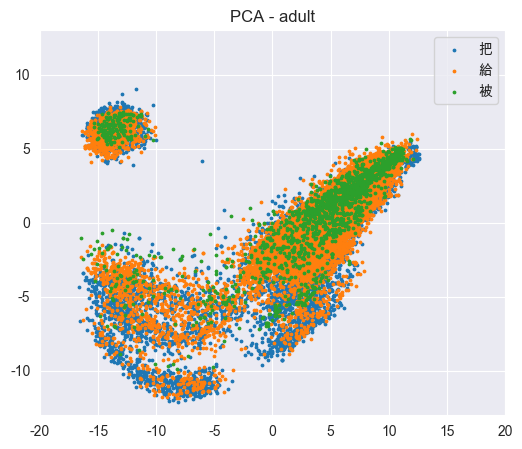

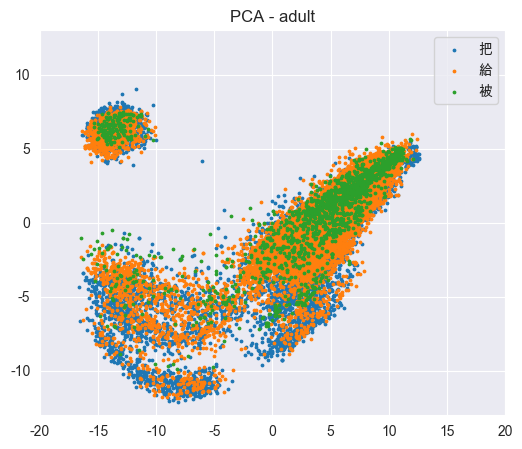

In [35]:
# Adults
plot_embeddings_pca(char_embeddings_by_group['adult'], 'adult')

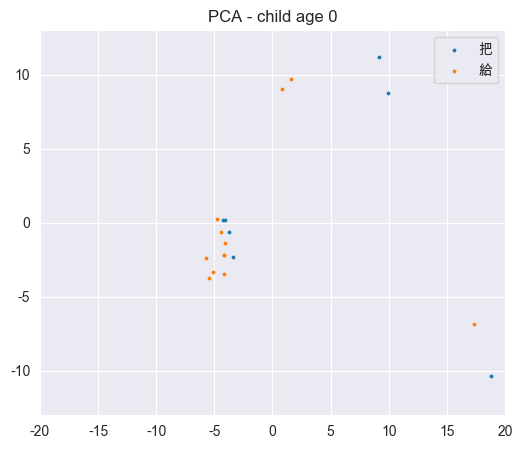

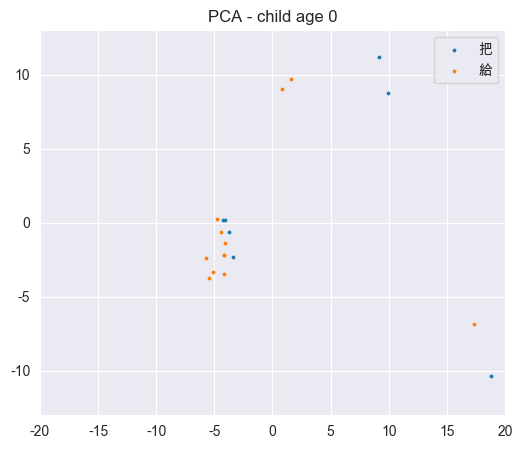

In [37]:
plot_embeddings_pca(char_embeddings_by_group['child'][0], 'child age 0')

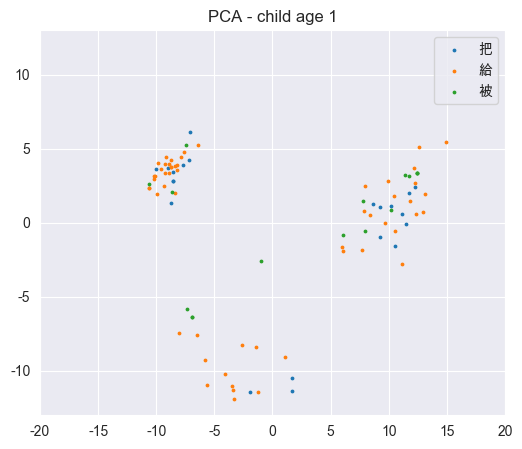

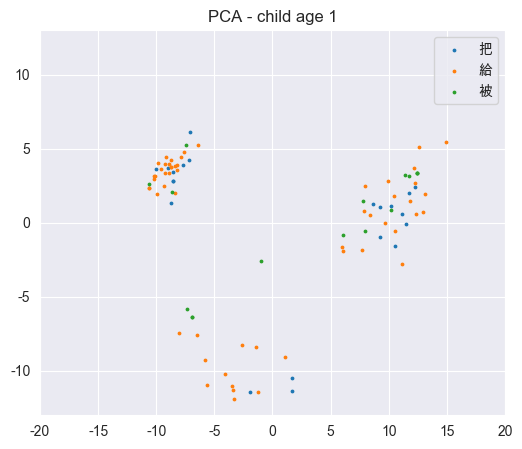

In [38]:
plot_embeddings_pca(char_embeddings_by_group['child'][1], 'child age 1')

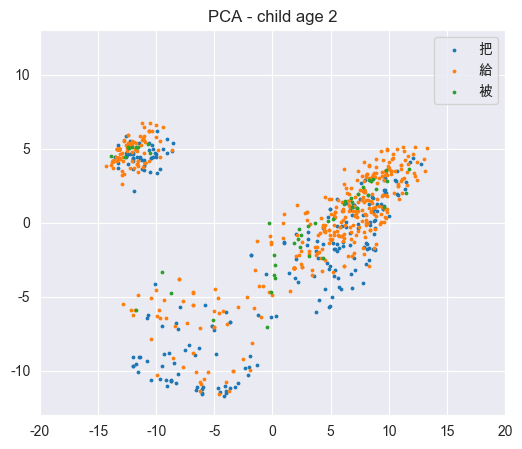

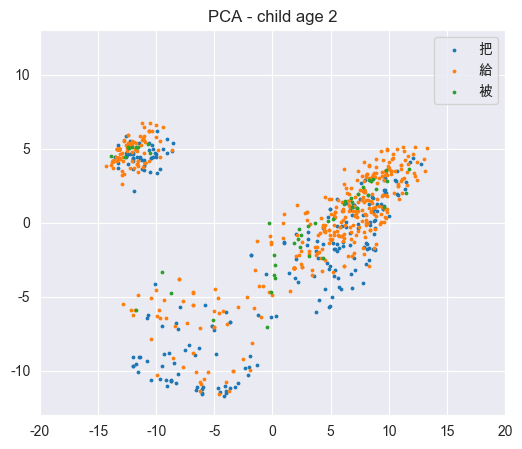

In [39]:
plot_embeddings_pca(char_embeddings_by_group['child'][2], 'child age 2')

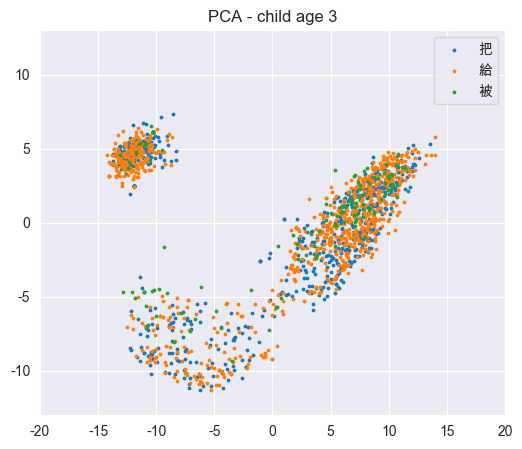

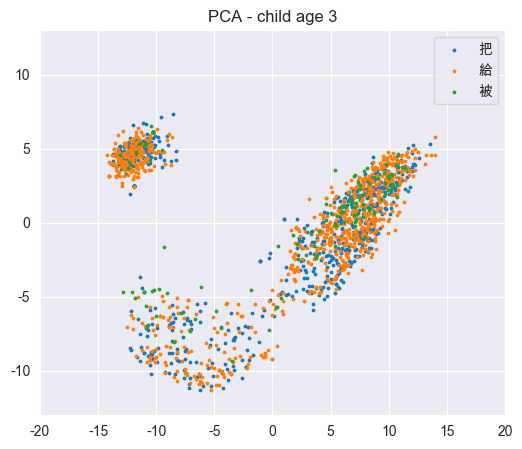

In [40]:
plot_embeddings_pca(char_embeddings_by_group['child'][3], 'child age 3')

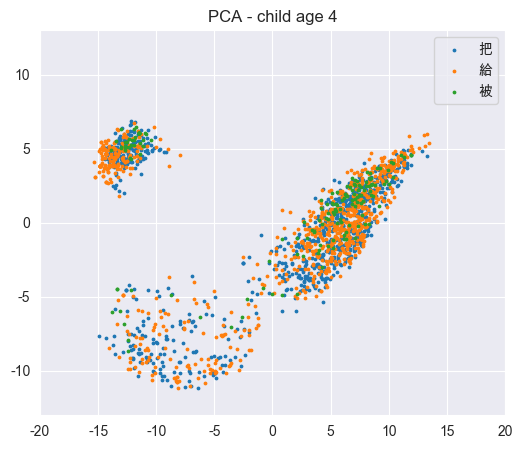

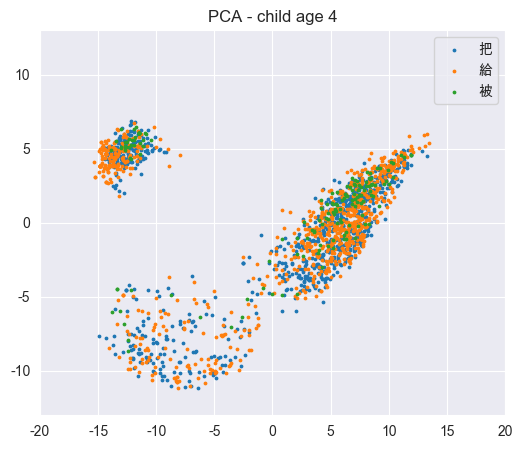

In [41]:
plot_embeddings_pca(char_embeddings_by_group['child'][4], 'child age 4')

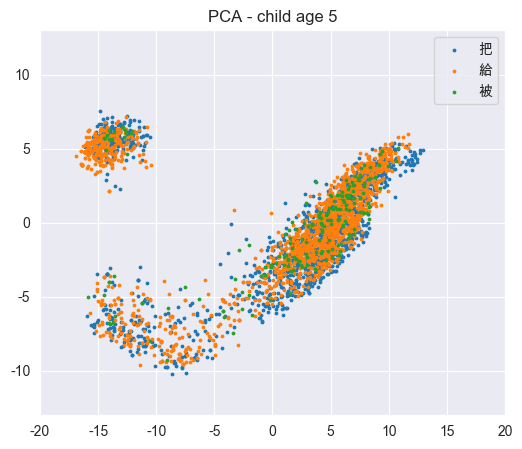

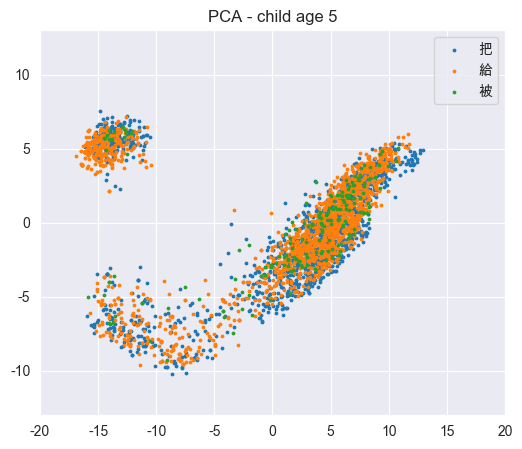

In [42]:
plot_embeddings_pca(char_embeddings_by_group['child'][5], 'child age 5')

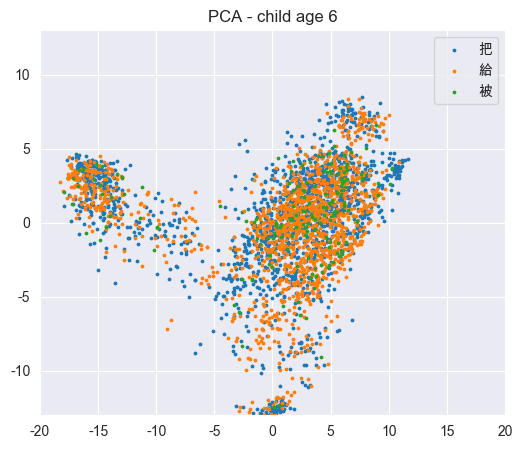

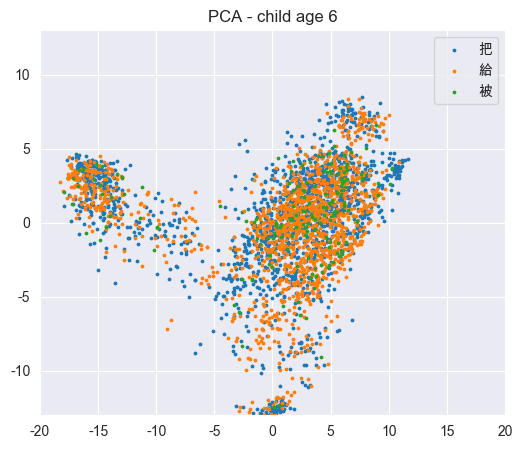

In [43]:
plot_embeddings_pca(char_embeddings_by_group['child'][6], 'child age 6')

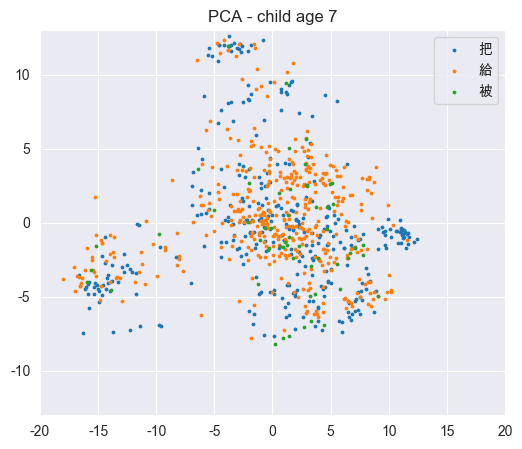

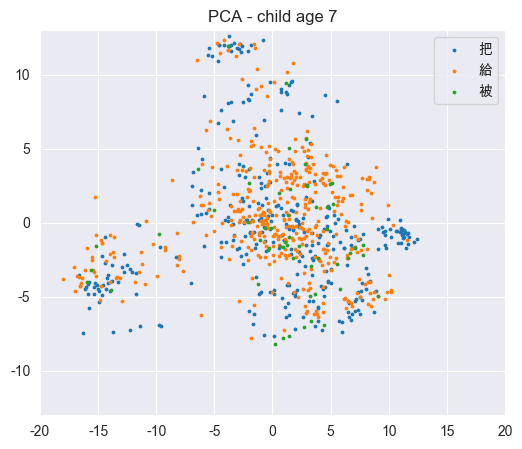

In [44]:
plot_embeddings_pca(char_embeddings_by_group['child'][7], 'child age 7')

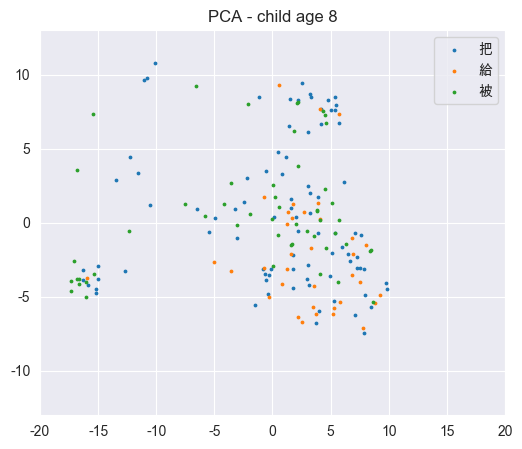

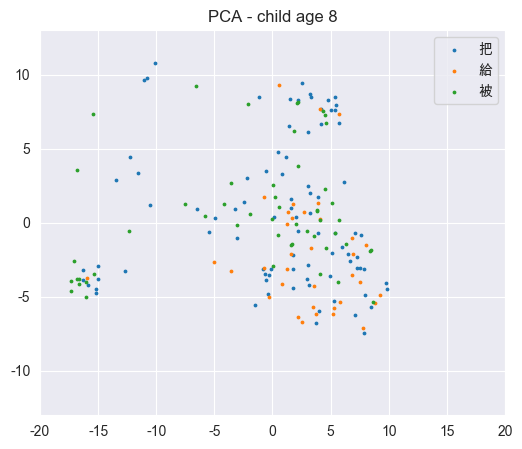

In [45]:
plot_embeddings_pca(char_embeddings_by_group['child'][8], 'child age 8')

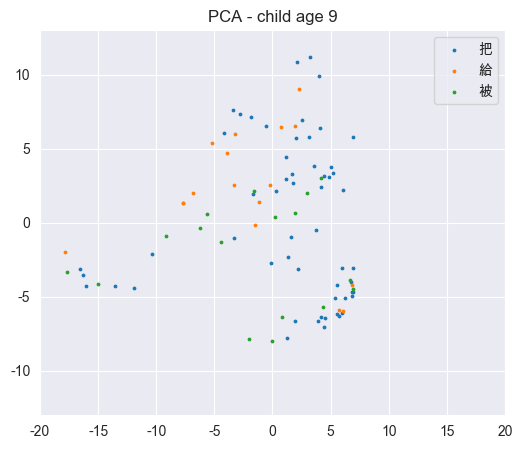

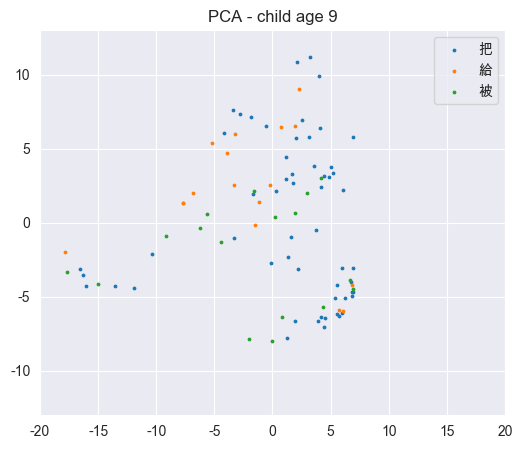

In [46]:
plot_embeddings_pca(char_embeddings_by_group['child'][9], 'child age 9')

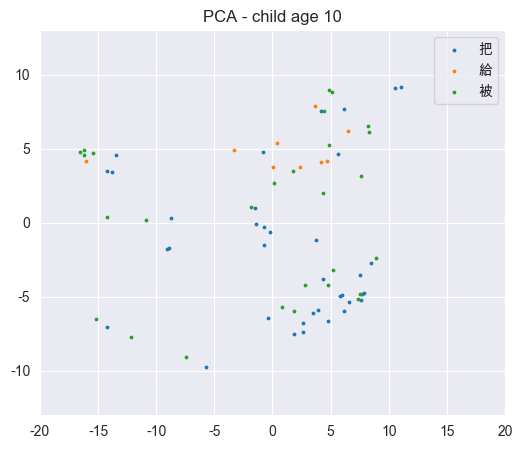

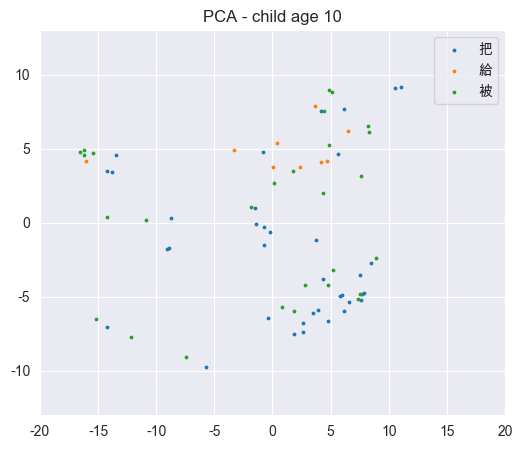

In [47]:
plot_embeddings_pca(char_embeddings_by_group['child'][10], 'child age 10')

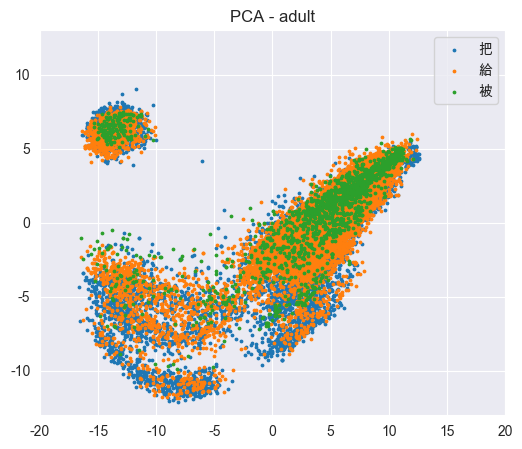

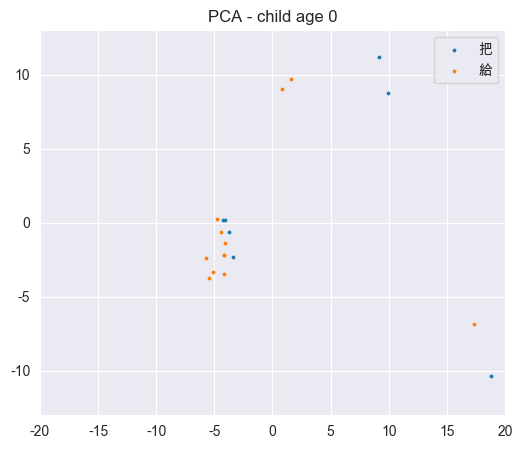

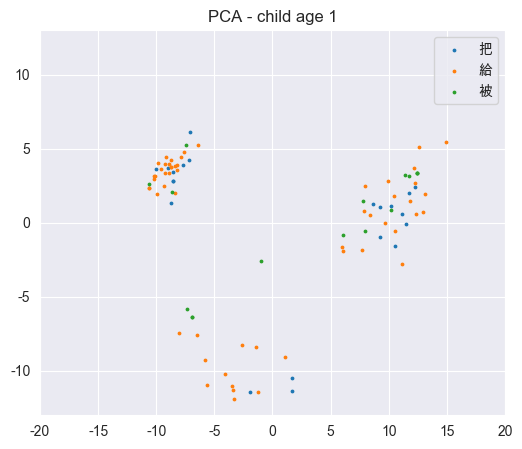

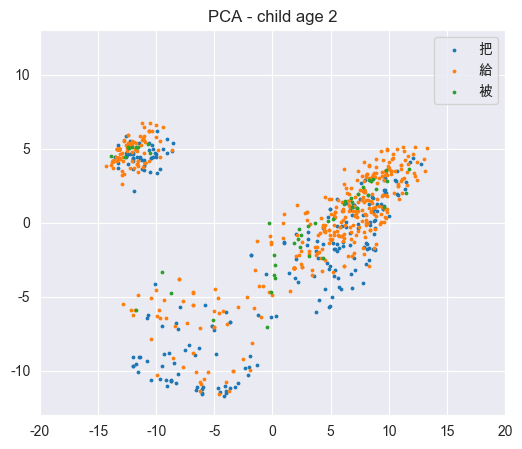

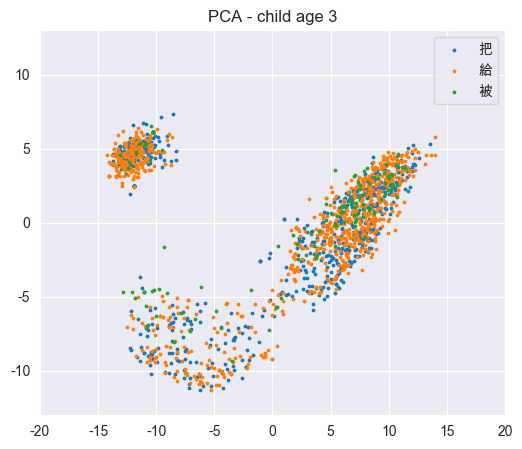

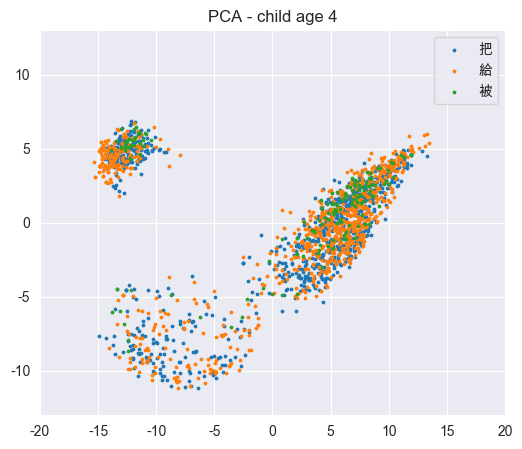

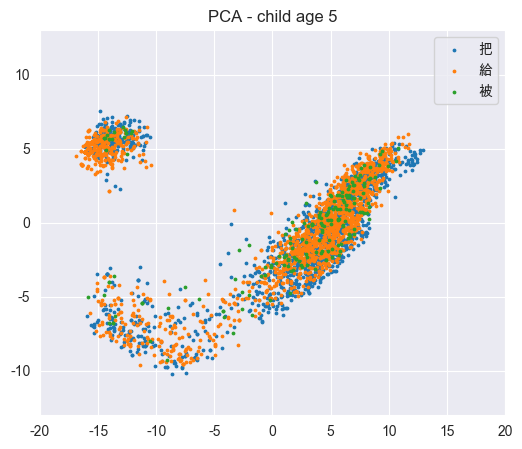

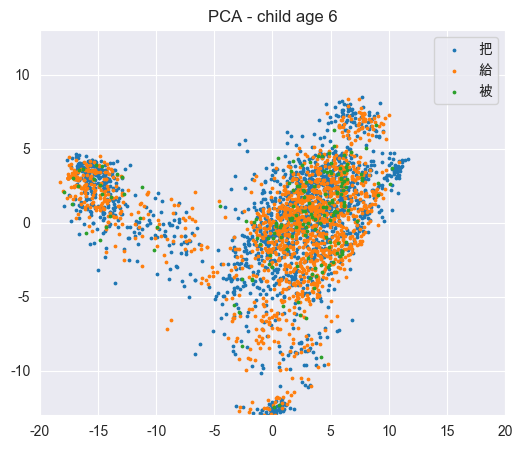

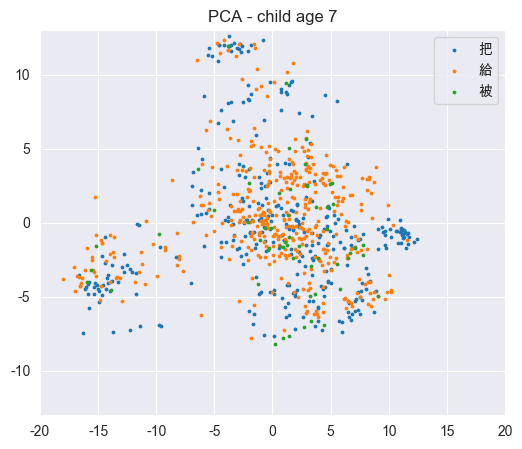

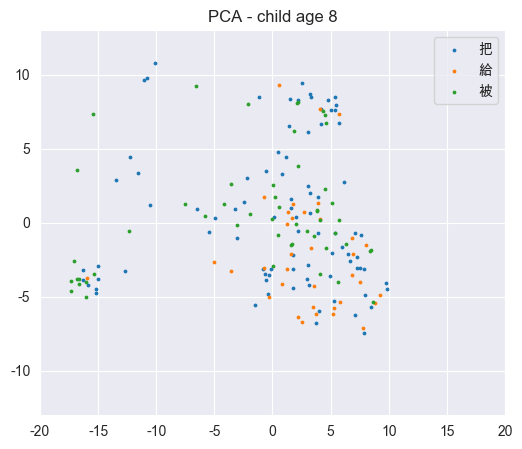

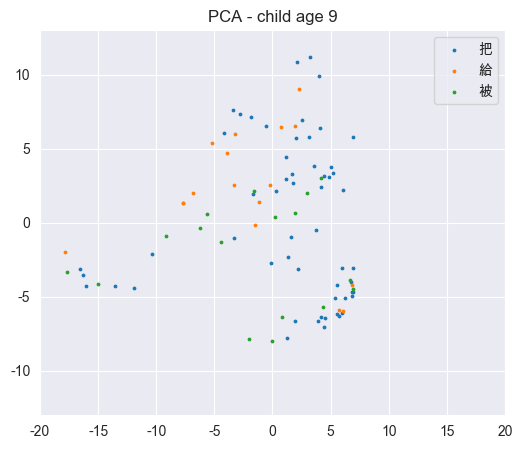

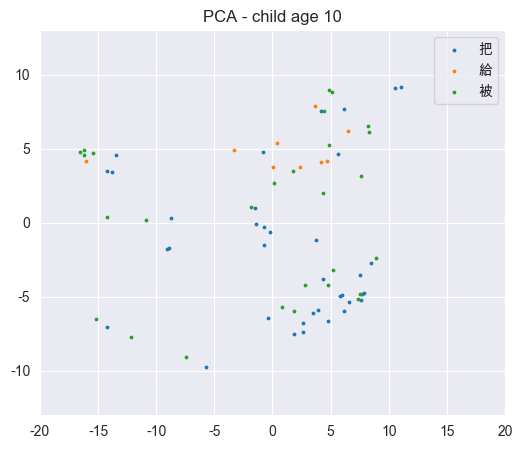

In [48]:
!pip install imageio
import imageio
import io
import matplotlib.pyplot as plt

images = []

# Adults
fig = plot_embeddings_pca(char_embeddings_by_group['adult'], 'adult')
buf = io.BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)
images.append(imageio.v2.imread(buf))
plt.close(fig)
buf.close()

# Children by age (sorted)
for age in sorted(char_embeddings_by_group['child'].keys(), key=int):
    fig = plot_embeddings_pca(char_embeddings_by_group['child'][age], f'child age {age}')
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    images.append(imageio.v2.imread(buf))
    plt.close(fig)
    buf.close()

imageio.mimsave('embeddings_animation_new.gif', images, fps=1)


In [49]:
from sklearn.cluster import KMeans
import random

def inspect_clusters(group_data, n_clusters=2, n_samples=10):
    embeddings = []
    utterances = []
    chars = []

    for char, vecs in group_data.items():
        for vec, utt in vecs:
            embeddings.append(vec)
            utterances.append(utt)
            chars.append(char)

    if len(embeddings) < n_clusters:
        print("Not enough embeddings for clustering.")
        return

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(embeddings)

    # Group utterances by cluster
    cluster_utterances = {i: [] for i in range(n_clusters)}
    for label, utt, char in zip(labels, utterances, chars):
        cluster_utterances[label].append((char, utt))

    # Print samples
    for i in range(n_clusters):
        print(f"\n--- Cluster {i} ---")
        samples = random.sample(cluster_utterances[i], min(n_samples, len(cluster_utterances[i])))
        for char, utt in samples:
            print(f"[{char}] {utt}")


In [50]:
inspect_clusters(char_embeddings_by_group['adult'], n_clusters=2, n_samples=10)


--- Cluster 0 ---
[把] 啊 你 先 把 他 全部 翻 過來
[被] 那 你 有沒有 被 什麼 東西 嚇 到 過
[把] 那 你 把 聽診器 聽聽看 小熊維尼
[把] 你 幫 我 把 那 張 紙 撿 起 來
[把] 好 我們 把 鴨 鴨鴨 寶寶 和 鴨 媽媽 把 他 們 拼 在 一起 喔
[給] 你 編 給 阿姨 聽 想想看 這 個 森林 會 發生 什麼 事
[把] 喬治 怕 別人 把 它 東西 給 吃 掉 是 吧
[給] 躺 下 來 就 給 你
[把] 怎麼 把 它們 接 起來
[把] 想不想 把 這 個 搭 起來

--- Cluster 1 ---
[給] 那 給 我
[把] 把 魚 弄 出來 對 吧
[把] 喔 把 不 好的 東西 夾 出來 喔
[被] 被 任何 什麼 東西 嚇 到 過
[把] 你 把 它 放 在 鋼琴 上 為什麼 放 鋼琴 上
[給] 給 那 個 花 塗 上 紅色 吧
[把] 先 把 他 擋 一 個 打 一 個 止 痛 針 啊
[把] 他 把 貓 咪 給 怎麼樣
[被] 又 被 送 進 了 醫院
[把] 它 把 水 打翻 了


In [53]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_and_sample_clusters(group_data, group_name, n_clusters=3, n_samples=10):
    embeddings = []
    char_labels = []
    utterances = []

    # Unpack (vec, utt) pairs
    for char, vecs in group_data.items():
        for vec, utt in vecs:
            embeddings.append(vec)
            char_labels.append(char)
            utterances.append(utt)

    if len(embeddings) < n_clusters:
        print(f"Not enough data for clustering in {group_name}")
        return

    embeddings = np.vstack(embeddings)

    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings)

    # Plot
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=3, alpha=1)
    plt.title(f"PCA with Clusters - {group_name}")
    plt.grid(True)
    plt.ylim((-13, 13))
    plt.xlim((-20, 20))
    plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster')
    plt.show()

    # Print sample utterances
    print(f"\nSample utterances by cluster for {group_name}:")
    cluster_data = {i: [] for i in range(n_clusters)}
    for cluster_id, char, utt in zip(cluster_labels, char_labels, utterances):
        cluster_data[cluster_id].append((char, utt))

    for cluster_id, items in cluster_data.items():
        print(f"\n--- Cluster {cluster_id} ---")
        grouped_by_char = {}
        for char, utt in items:
            grouped_by_char.setdefault(char, []).append(utt)
        for char in sorted(grouped_by_char.keys()):
            examples = random.sample(grouped_by_char[char], min(n_samples, len(grouped_by_char[char])))
            print(f"\n{char}:")
            for ex in examples:
                print("  ", ex)


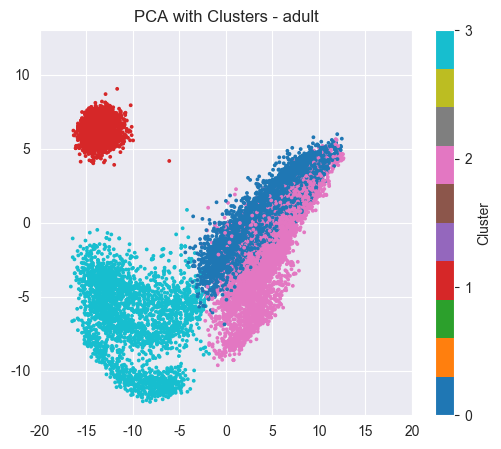


Sample utterances by cluster for adult:

--- Cluster 0 ---

把:
   四 個 把 它 放 好
   一 不 小心 啊 把 果汁 打翻 了 耶
   阿姨 把 他 放 進去 好不好
   你 看 它 把 紙 啊 布 啊 都 弄 得 爛爛 的 對不對
   嗯 對 就是 看 把 它 敘述 的 翻 一 遍 然後 來講 給 多 啦 聽
   積木 把 它 放 旁邊 去
   那 我們 一塊 把 這 個 房間 把 家 收拾 一下 吧
   你 你 把 把 它 拿 下來
   欸 會不會 是 用 這 個 把 他 藥藥 抹 一 抹
   後來 就是 這 個 主人 把 貓 關 在 這 個 家 裡 了
   結果 一 不 小心 呀 把 水果 給 把 那個 果汁 啦 給 打翻 了
   這 個 把子 上面
   顏色 把 它 都 拼 上去
   拿 這 個 把 那個 收一收 好不好
   沒 呀 有 的 小朋友 自說自話 跑 到 圖書館 把 書 拿掉 啦 是 有 的 呀 被 捉 住 啦
   幫 爸爸 把 球 放 到 箱子 裡面
   不 吃 等 下 阿姨 把 肉 肉 都 吃 光 咯
   嗯 媽媽 把 那 個 米菲兎 找 出來
   噢 對 了 你 知道 它 有 個 好 朋友 掃把 要 配
   可是 小 寶貝 他 把 廚房 全部 弄 得 亂七八糟
   弄 東西 把 他 修一修
   就是 你 看看 他 一 個 手 能 把 板 怎麼樣
   把 毛毛蟲 把 毛毛蟲 給 媽媽 玩
   豬 爸爸 把 晚餐 都 吃 過 啦
   不 乖 阿姨 把 你 關 這裏 哦
   這 個 把 他 收 起來 了 好不好
   你 看 主人 把 它 放 在 花 下面 曬 太陽 睡覺
   還是 我 把
   兎 媽媽 到 樹林 裡 採 蘑菇 了 小 兔子 呢 把 門 關 得 緊緊 的
   你 要 把 那個 積木 拆拆 把 他 收 起來
   對 要 用 到 盆 要 用 到 鐵 鍬 掃把
   路人 把 這 只 流浪 貓 帶 回 了 家
   嗯 然後 呢 你 可以 去 試一試 把 你 想 的 先 去 試一試
   因為 桃太郎 把 東西 去 還給 人家
   好 了 這 個 把 椅子 請 誰 坐
   再 試 一次 放 在 地 上 把

In [59]:
plot_and_sample_clusters(char_embeddings_by_group['adult'], "adult", n_clusters=4, n_samples=100)


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_sentence_lengths_by_age(data, target_chars):
    records = []

    # Children
    for age, utterances in data["child"].items():
        for utt in utterances:
            tokens = utt.strip().split()
            length = len(tokens)
            for char in target_chars:
                if char in tokens:
                    records.append({
                        "age": age,
                        "char": char,
                        "length": length
                    })

    # Adults
    for utt in data["adult"]:
        tokens = utt.strip().split()
        length = len(tokens)
        for char in target_chars:
            if char in tokens:
                records.append({
                    "age": "adult",
                    "char": char,
                    "length": length
                })

    df = pd.DataFrame(records)

    # Sort ages: numeric ages first, then 'adult' last
    age_order = sorted([a for a in df["age"].unique() if a != "adult"]) + ["adult"]
    df["age"] = pd.Categorical(df["age"], categories=age_order, ordered=True)

    for char in target_chars:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df[df["char"] == char], x="age", y="length")
        plt.title(f"Sentence length by age for '{char}'")
        plt.ylabel("Length (words)")
        plt.xlabel("Age")
        plt.grid(True)
        plt.show()


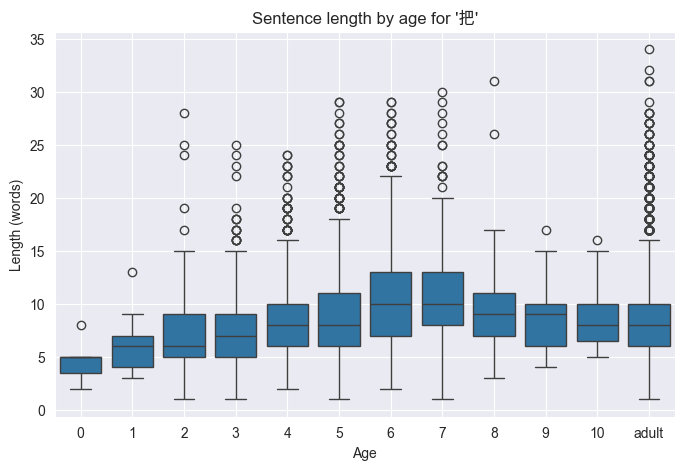

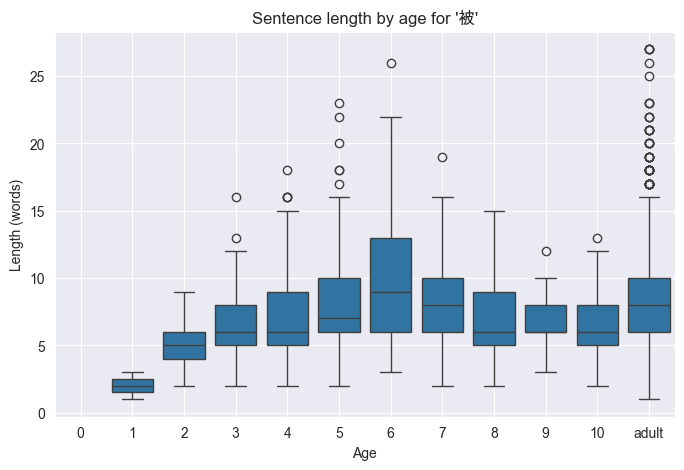

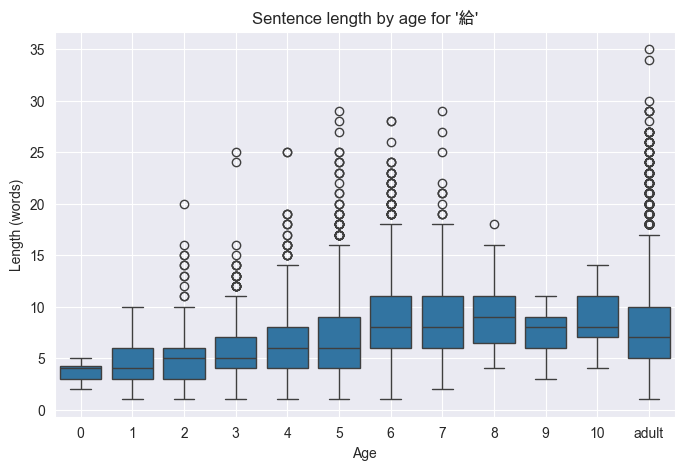

In [63]:
plot_sentence_lengths_by_age(data, ["把", "被", "給"])